In [98]:
import pandas
import math

In [99]:
# Load the dataset
company_directorships = pandas.read_csv('company_directorships.csv')
company_directorships.software_background = (
     company_directorships.software_background
         .fillna('f')
         .str.lower()
         .map(lambda x: x == 't')
         )
company_directorships.software_background = company_directorships.software_background.map(lambda x: x == 't')
company_directorships.sample(5)

,company_name,cikcode,director_name,software_background,start_date,end_date
12485,Unum Group,5513,RONALD P. O'HANLEY,False,2015-04-09,2023-04-13
10963,S&P Global Inc.,64040,MARCO ALVERÀ,False,2017-03-13,2020-03-30
8198,MICRON TECHNOLOGY INC,723125,MERCEDES JOHNSON,False,2015-12-15,2017-12-07
6671,Invesco Pennsylvania Value Municipal Income Trust,895528,JOEL W. MOTLEY,False,2020-06-18,2024-07-02
9251,OWENS & MINOR INC/VA/,75252,MARK F. MCGETTRICK,False,2018-03-26,2022-03-17


In [100]:
compensation_and_demographics_raw = pandas.read_csv('director-details.csv')
compensation_and_demographics_raw['NAME'] = compensation_and_demographics_raw.name.str.upper()

def most_common(series):
    mode_values = series.mode()
    if len(mode_values) > 0:
        return mode_values[0]
    return None
    
compensation_and_demographics = pandas.DataFrame({
    'age': compensation_and_demographics_raw.groupby('NAME').age.max(),
    'compensation': compensation_and_demographics_raw.groupby('NAME').compensation.sum(),
    'gender': compensation_and_demographics_raw.groupby('NAME').gender.agg(most_common)
})
compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)
compensation_and_demographics

,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139
...,...,...,...,...
ZACKARY IRANI,58,360103,male,5.556428
ZAHID AFZAL,62,0,male,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,5.278664


In [101]:
compensation_and_demographics.gender.value_counts(dropna=False)

gender
male       3850
female     1550
None         19
unknown       2
Name: count, dtype: int64

In [102]:
# --- handle missing or unknown genders ---
# drop rows where gender is None or 'unknown'
mask = compensation_and_demographics.gender.isin([None, 'unknown'])
print(f"Dropping {mask.sum()} directors with missing gender")
compensation_and_demographics = compensation_and_demographics[~mask]


Dropping 21 directors with missing gender


In [103]:
compensation_and_demographics.gender.value_counts(dropna=False)

gender
male      3850
female    1550
Name: count, dtype: int64

In [110]:
directorship_counts = company_directorships.groupby('director_name').company_name.nunique().sort_values()
directorship_counts

director_name
YVETTE DAPREMONT BRIGHT     1
A. SCOTT PARKER III         1
A. SHANE SANDERS            1
A. THOMAS BENDER            1
A.F. (PETE) SLOAN           1
                           ..
LARRY SOLL                 13
PREMA MATHAI-DAVIS         13
JAMES T. BUNCH             13
ROBERT C. TROCCOLI         13
ALBERT R. DOWDEN           14
Name: company_name, Length: 11827, dtype: int64

Text(0, 0.5, 'How Many Directors (log10)')

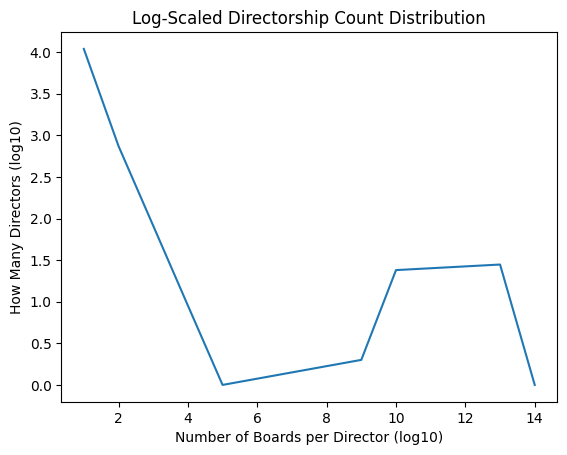

In [111]:
ax = directorship_counts.value_counts().sort_index().map(math.log10).plot()
ax.set_title("Log‐Scaled Directorship Count Distribution")
ax.set_xlabel("Number of Boards per Director (log10)")
ax.set_ylabel("How Many Directors (log10)")

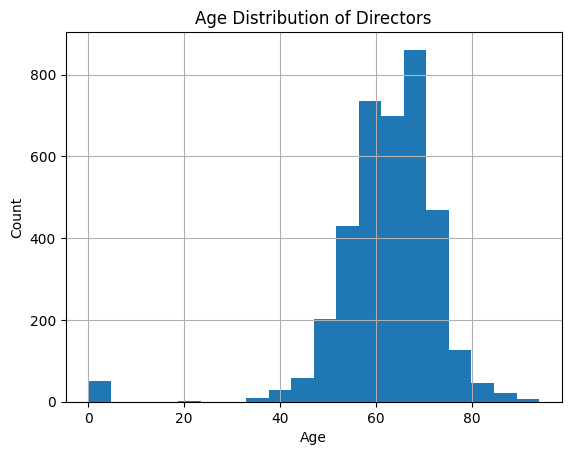

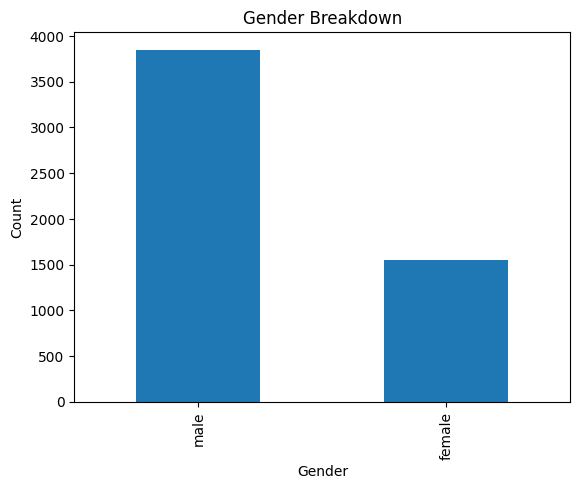

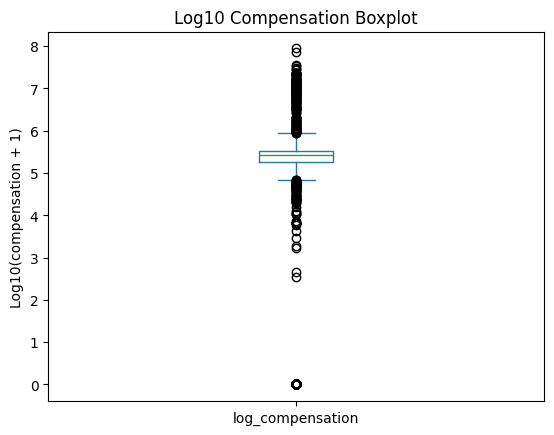

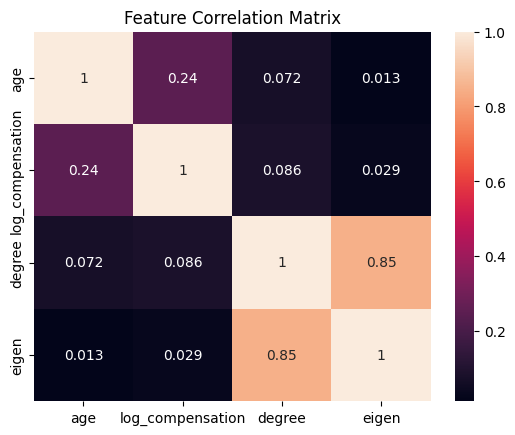

In [109]:
import matplotlib.pyplot as plt

# 1) Age histogram
people_df['age'].hist(bins=20)
plt.title("Age Distribution of Directors"); plt.xlabel("Age"); plt.ylabel("Count")
plt.show()

# 2) Gender bar chart
compensation_and_demographics.gender.value_counts().plot.bar()
plt.title("Gender Breakdown"); plt.xlabel("Gender"); plt.ylabel("Count")
plt.show()

# 3) Compensation boxplot (log)
people_df['log_compensation'].plot.box()
plt.title("Log10 Compensation Boxplot")
plt.ylabel("Log10(compensation + 1)")
plt.show()

# 4) Correlation heatmap
corr = people_df[['age','log_compensation','degree','eigen']].corr()
import seaborn as sns
sns.heatmap(corr, annot=True)
plt.title("Feature Correlation Matrix")
plt.show()


In [81]:
import networkx
import networkx.algorithms
graph = networkx.Graph()

In [82]:
people = []
companies = []
for company_name, director_name in zip(company_directorships.company_name, company_directorships.director_name):
    graph.add_edge(company_name, director_name)
    people.append(director_name)
    companies.append(company_name)

In [ ]:
biggest_connected_graph = graph.subgraph(list(networkx.connected_components(graph))[0])
# find the largest connected component by node‐count
# subgraph of the single largest connected component

largest_cc = max(networkx.connected_components(graph), key=len)
biggest_connected_graph = graph.subgraph(largest_cc).copy()


In [33]:
%%time
centrality = pandas.DataFrame({
    'eigen': pandas.Series(
        networkx.eigenvector_centrality(
            biggest_connected_graph,
            max_iter=1_000,
            tol=1e-06,)
        ),
    'degree': pandas.Series(networkx.algorithms.degree_centrality(biggest_connected_graph)),
})
centrality['is_person'] = centrality.index.map(lambda x: x in people)

CPU times: total: 1.14 s
Wall time: 1.14 s


Centrality measures

Eigenvector centrality: assigns higher score to nodes connected to other high-scoring nodes (identifies truly influential directors).

Degree centrality: fraction of possible connections the node has (directors on many boards).

# – eigenvector centrality: measures how “influential” a node is by giving higher score to nodes 
#   connected to other high‐score nodes (so a director linked to highly connected companies → higher eigen).
# – degree centrality: proportion of nodes a node is directly connected to (so directors sitting 
#   on many different boards → high degree).


In [112]:
people_df = centrality[centrality.is_person].merge(compensation_and_demographics, left_index=True, right_index=True)

In [113]:
people_df.sort_values('eigen', ascending=False)

,eigen,degree,is_person,is_company,is_software_company,is_software_person,age,compensation,gender,log_compensation
JOEL W. MOTLEY,1.024389e-01,0.001585,True,False,False,False,72,3118870,male,6.493997
DANIEL S. VANDIVORT,1.024389e-01,0.001585,True,False,False,False,69,3353265,male,6.525468
DOUGLAS SHARP,1.024389e-01,0.001585,True,False,False,False,50,0,male,0.000000
ELI JONES,1.024389e-01,0.001585,True,False,False,False,63,3063255,male,6.486183
TERESA M. RESSEL,1.024389e-01,0.001585,True,False,False,False,62,3190130,female,6.503809
...,...,...,...,...,...,...,...,...,...,...
ANDREW H. REICH,8.400282e-35,0.000122,True,False,False,False,69,120000,male,5.079185
RICHARD P. HOWARD,8.342633e-35,0.000122,True,False,False,False,78,0,male,0.000000
NANCY J. FLOYD PRUE,8.342633e-35,0.000122,True,False,False,False,70,50356,female,4.702060
LAWRENCE A. KOBRIN,8.342633e-35,0.000122,True,False,False,False,91,30356,male,4.482259


In [114]:
company_directorships[company_directorships.director_name == 'ELIZABETH KRENTZMAN']

,company_name,cikcode,director_name,software_background,start_date,end_date
6297,Invesco Advantage Municipal Income Trust II,908993,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6352,Invesco Bond Fund,5094,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6407,Invesco California Value Municipal Income Trust,895531,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6462,Invesco High Income Trust II,846671,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6512,Invesco Municipal Income Opportunities Trust,835333,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6546,Invesco Municipal Opportunity Trust,884152,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6601,Invesco Municipal Trust,877463,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6656,Invesco Pennsylvania Value Municipal Income Trust,895528,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6706,Invesco Quality Municipal Income Trust,885125,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6740,Invesco Senior Income Trust,1059386,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02


In [115]:
import sklearn.cluster

In [116]:
import sklearn.preprocessing
robust_scaler = sklearn.preprocessing.RobustScaler()
age_and_demographics_scaled = robust_scaler.fit_transform(people_df[['age', 'log_compensation', 'degree', 'eigen']])


In [117]:
dbscan = sklearn.cluster.DBSCAN(eps=0.4)

# cluster directors by age, compensation, and centrality scores
dbscan = sklearn.cluster.DBSCAN(
    eps=0.4,
    min_samples=5,       # ensure small noise clusters are treated as outliers
    metric='euclidean'   # default, but explicit for clarity
)
# eps is the maximum distance between two samples for one to be considered as in the neighborhood of the other.

people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_df.cluster_id.value_counts()

cluster_id
 1    3101
 0     384
 2     107
-1      72
 3      24
 4      19
 7       8
 6       5
 5       3
Name: count, dtype: int64

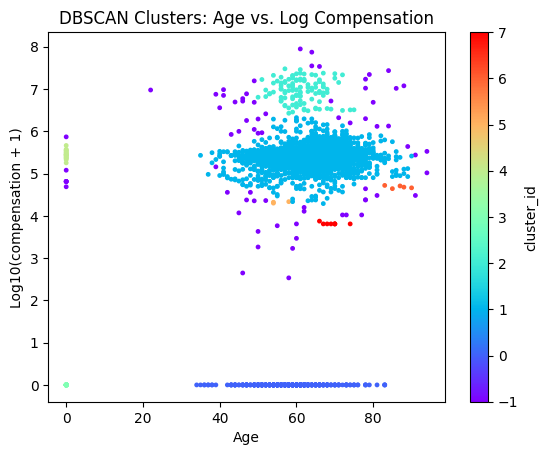

In [118]:
ax = people_df.plot.scatter(
    x='age', y='log_compensation',
    c='cluster_id', cmap='rainbow', s=6
)
ax.set_title("DBSCAN Clusters: Age vs. Log Compensation")
ax.set_xlabel("Age")
ax.set_ylabel("Log10(compensation + 1)")
plt.show()


### Cluster Interpretation
- **Cluster 1 (n=3117):** Core group of mid‐career (55–75 yrs) directors earning average to above‐average compensation.
- **Cluster 0 (n=385):** Early‐mid career (45–65 yrs), slightly below‐average compensation.
- **Clusters 2–7 (small groups):** Outliers (e.g., very high pay or very young/old).
- **Label –1:** Noise points not fitting any cluster.


In [91]:
people_df.loc['ELIZABETH KRENTZMAN']

eigen                  0.102439
degree                 0.001585
is_person                  True
is_company                False
is_software_company       False
is_software_person        False
age                          65
compensation            3408245
gender                   female
log_compensation       6.532531
cluster_id                    2
Name: ELIZABETH KRENTZMAN, dtype: object

## Conclusion
- The board network is dominated by a large mid‐career cohort (Cluster 1).
- A handful of “super-directors” emerge via eigenvector centrality (e.g. Daniel S. Vandivort).
- DBSCAN outliers highlight distinct sub-populations (high-pay, early‐entry).
- This analysis shows how network position, age, and compensation interplay in director careers.
